In [7]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dropout,Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
moview_reviews=pd.read_csv('IMDB Dataset.csv')

In [10]:
moview_reviews.head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


<AxesSubplot:xlabel='sentiment', ylabel='count'>

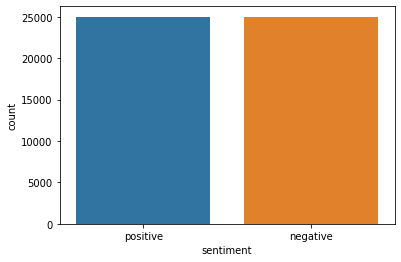

In [11]:
import seaborn as sns 
sns.countplot(x='sentiment',data=moview_reviews)

In [20]:
def preprocess_text(sen):
    # remove html tags
    sentence=remove_tags(sen)

    #removing punctuation

    sentence=re.sub('[^a-zA-Z]',' ',sentence)

    #remove single char

    sentence=re.sub(r'\s+[a-zA-Z]\s+',' ',sentence)

    # remove multiple spaces

    sentence=re.sub(r'\s+',' ',sentence)

    return sentence

In [21]:
TAG_RE=re.compile(r'<[*>]+>')

def remove_tags(text):
    return TAG_RE.sub('',text)

In [22]:
x=[]
sentences=list(moview_reviews['review'])
for sen in sentences:
    x.append(preprocess_text(sen))

In [23]:
x[0]

'One of the other reviewers has mentioned that after watching just Oz episode you ll be hooked They are right as this is exactly what happened with me br br The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the word br br It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to many Aryans Muslims gangstas Latinos Christians Italians Irish and more so scuffles death stares dodgy dealings and shady agreements are never far away br br would say the main appeal of the show is due to the fact that it goes where other shows wouldn dare For

In [24]:
y=moview_reviews['sentiment']

y=np.array(list(map(lambda x: 1 if x=='positive' else 0,y)))

In [26]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=0)

In [28]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)


In [29]:
vocab_size=len(tokenizer.word_index)+1

maxlen=100

X_train=pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test=pad_sequences(X_test,padding='post',maxlen=maxlen)

In [30]:
X_train

array([[  10,   41,    1, ...,    0,    0,    0],
       [2299,    4, 1714, ...,   70,  657, 1388],
       [   7,    6,    6, ..., 2814,    6,    6],
       ...,
       [1721,   12,   66, ...,    1,   77,  635],
       [ 446,    2, 3177, ...,  171, 2508, 1388],
       [   1,   58,  501, ...,  256,  829,  263]], dtype=int32)

In [33]:
from numpy import array
from numpy import asarray
from numpy import  zeros

embeddings_dictionary=dict()
glove_file=open('glove.6B.100d.txt',encoding='utf8')

for line in glove_file:
    records=line.split()
    word=records[0]
    vector_dimensions=asarray(records[1:],dtype='float32')
    embeddings_dictionary[word]=vector_dimensions
glove_file.close()


In [35]:
embedding_matrix=zeros((vocab_size,100))
for word, index in tokenizer.word_index.items():
    embedding_vector=embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index]=embedding_vector

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D,Dense,MaxPool1D,Flatten,Input
import numpy as np
model=Sequential()

2021-11-23 12:00:17.524822: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2021-11-23 12:00:17.524857: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-23 12:00:17.524882: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HP-Laptop-15-da0xxx-def03a20): /proc/driver/nvidia/version does not exist
2021-11-23 12:00:17.525123: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
embedding_layer=Embedding(vocab_size,100,weights=[embedding_matrix],input_length=maxlen,trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128,5,activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9076600   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 9,140,857
Trainable params: 64,257
Non-trainable params: 9,076,600
_________________________________________________________________


In [43]:
history=model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=0.2)

score=model.evaluate(X_test,y_test,verbose=1)

2021-11-23 12:06:06.577463: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-23 12:06:06.598670: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2899885000 Hz


Epoch 1/6
250/250 [==============================] - 15s 49ms/step - loss: 0.5038 - acc: 0.7489 - val_loss: 0.3971 - val_acc: 0.8214
Epoch 2/6
250/250 [==============================] - 10s 40ms/step - loss: 0.3658 - acc: 0.8380 - val_loss: 0.3764 - val_acc: 0.8288
Epoch 3/6
250/250 [==============================] - 13s 53ms/step - loss: 0.3145 - acc: 0.8678 - val_loss: 0.3595 - val_acc: 0.8384
Epoch 4/6
250/250 [==============================] - 13s 51ms/step - loss: 0.2802 - acc: 0.8838 - val_loss: 0.3770 - val_acc: 0.8294
Epoch 5/6
250/250 [==============================] - 12s 48ms/step - loss: 0.2497 - acc: 0.9021 - val_loss: 0.3390 - val_acc: 0.8472
Epoch 6/6
313/313 [==============================] - 2s 5ms/step - loss: 0.3521 - acc: 0.8494


In [44]:
print("test score",score[0])

test score 0.35211434960365295


In [45]:
print("test accuracy",score[1])

test accuracy 0.849399983882904


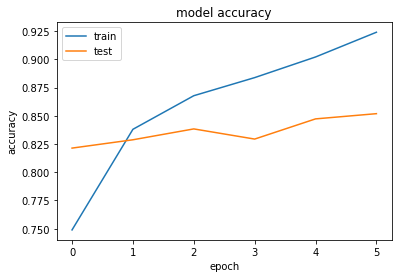

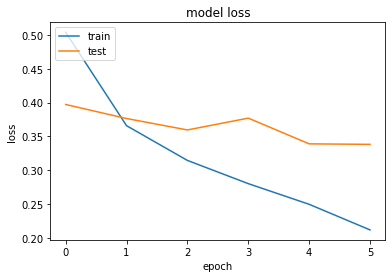

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train","test"],loc='upper left')
plt.show()



plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train","test"],loc='upper left')
plt.show()





In [ ]:
https://www.youtube.com/watch?v=Pf_6LiSTCt4